# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
C:\Users\dmwal\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [3]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
file_path = Path("Data/neighborhoods_coordinates.csv")
neighborhood_cod=pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [58]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = sfo_data["housing_units"]
    housing_units = housing_units.groupby([sfo_data.index]).mean()
    
    housing_units_figure = plt.figure()
    housing_units_plot = housing_units.plot.bar(
        x="Year",
        y="Housing Units",
        ylim = [365000, 390000],
        title="San Francisco Housing Units from 2010 to 2016"
    )
    return pn.pane.Matplotlib(housing_units_figure)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    gross_rent = sfo_data["gross_rent"].groupby("year").mean()
    average_gross_rent_figure = plt.figure()
    average_gross_rent_plot = (gross_rent.plot.line(
        x="Year",
        y="Gross Rent",
        title="Average Gross Rent by Year"
    ))
    plt.close(average_gross_rent_figure)
    
    return pn.pane.Matplotlib(average_gross_rent_figure)

def average_sales_price():
    """Average Sales Price Per Year."""
    average_sale_price = sfo_data["sale_price_sqr_foot"].groupby("year").mean()
    average_sale_price_figure = plt.figure()
    average_sale_price_plot = average_sale_price.plot.line(
        ylim=[300, 800],
        xlim=[2009, 2017],
        title="Average Gross Rent in SF"
    )
    plt.close(average_sale_price_figure)
    
    return pn.pane.Matplotlib(average_sale_price_figure)
    
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sf_dataset = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sf_neighborhood_data = sf_dataset[["housing_units", "sale_price_sqr_foot", "gross_rent"]]
    sf_neighborhood_plot = sf_neighborhood_data.hvplot.line(
        x = "year",
        y = "sale_price_sqr_foot",
        groupby = "neighborhood",
        title = "SF Neighborhood Sale Price per Square Foot"
    )
    
    return sf_neighborhood_plot 

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top_10 = sfo_data.drop(["housing_units", "gross_rent"], axis=1).groupby("neighborhood").mean().sort_values(by="sale_price_sqr_foot", ascending = False).head(10)
    
    return top_10

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    top_10_gr = sfo_data.drop(["housing_units", "sale_price_sqr_foot"], axis=1).groupby("neighborhood").mean().sort_values(by="gross_rent", ascending = False).head(10)
    
    return top_10_gr
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    avg_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()
    top_10 = avg_neighborhood.nlargest(10, "sale_price_sqr_foot").reset_index()
    top_10_ll = px.parallel_coordinates(
        top_10,
        color="sale_price_sqr_foot"
    )
    
    return top_10_ll

def parallel_categories():
    """Parallel Categories Plot."""
    avg_neighborhood_value = sfo_data.groupby([sfo_data["neighborhood"]]).mean()
    top_10_ex = avg_neighborhood_value.nlargest(10, "sale_price_sqr_foot").reset_index()
    top_10_ll_cat = px.parallel_categories(
        top_10_ex,
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color= "sale_price_sqr_foot",
        color_continuous_scale = px.colors.sequential.Inferno
    )
    
    return top_10_ll_cat

def neighborhood_map():
    """Neighborhood Map."""
    neighborhood_cod.rename(columns={"Neighborhood": "neighborhood"}, inplace=True)
    neighborhood_mean = pd.DataFrame(sfo_data.groupby("neighborhood").mean())
    sfo_data_cod = pd.merge(neighborhood_cod, neighborhood_mean, how="inner", on="neighborhood", sort=True)
    mapdiag = px.scatter_mapbox(sfo_data_cod,
                                lat = "Lat",
                                lon = "Lon",
                                size = "sale_price_sqr_foot",
                                color = "gross_rent",
                                zoom = 11,
                                hover_name = "neighborhood",
                                color_continuous_scale = px.colors.sequential.Jet
                               )
    return mapdiag.show()

def sunburst():
    """Sunburst Plot."""
    sf_dataset = sfo_data.groupby(["year", "neighborhood"]).mean()
    sf_neighborhood_data = sf_dataset[["housing_units", "sale_price_sqr_foot", "gross_rent"]]
    sf_neighborhood_data_df = pd.DataFrame(sf_neighborhood_data).reset_index()
    sunb_fig=px.sunburst(sf_neighborhood_data_df, names="neighborhood", parents="year", values="sale_price_sqr_foot")
    
    return sunb_fig.show()

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

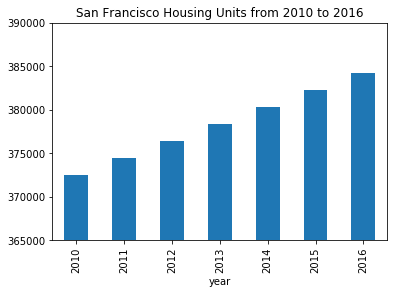

In [59]:
# Create a Title for the Dashboard
title= "Analysis of Real Estate Investments in San Francisco Market from 2010-2016"

# Create a tab layout for the dashboard
housing_unit = pn.Column("Number of Housing Units",
    housing_units_per_year()
)

housing_avg = pn.Column(
    "SF Housing Averages",
    average_gross_rent(),
    average_sales_price(),
    average_price_by_neighborhood()
)

expensive_neighborhood = pn.Column(
    "Top 10 Neighborhoods",
    top_most_expensive_neighborhoods()
)

parallel_plot = pn.Column(
    "Parallel Plot",
    parallel_coordinates(),
    parallel_categories()
)

map_plot = pn.Column(
    "Map Plot",
    neighborhood_map(),
)
# Create the dashboard
panel = pn.Tabs(("Number of Housing Units", housing_unit),
                ("SF Housing Averages", housing_avg),
                ("Top 10 Neighborhoods",expensive_neighborhood),
                ("Parallel Plot", parallel_plot),
                ("Map Plot", map_plot)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [2] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [4] Column
        [0] Markdown(str)
        [1] Str(None)
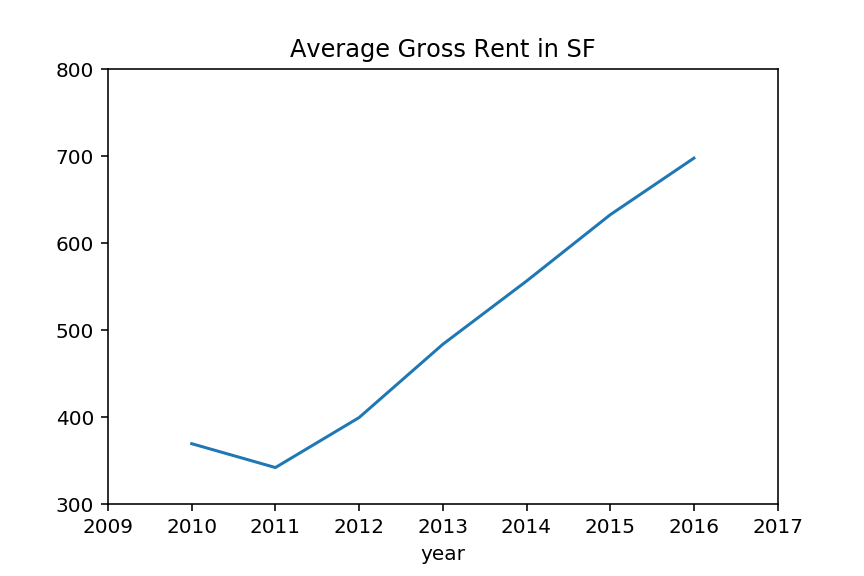
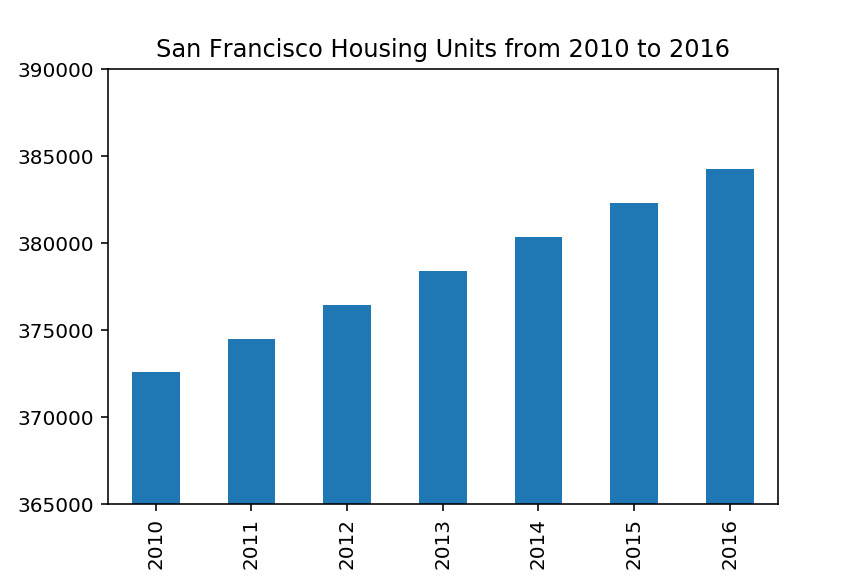
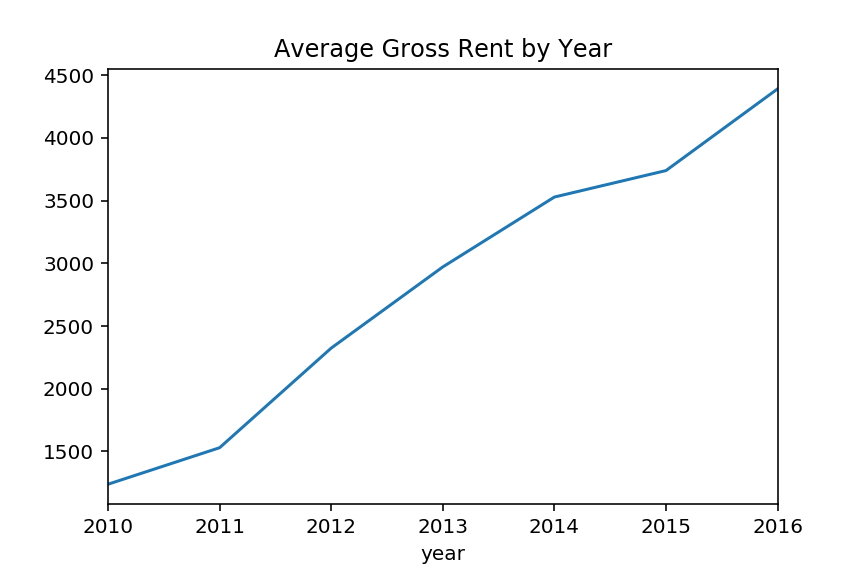

In [60]:
# Serve the# dashboard
panel.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
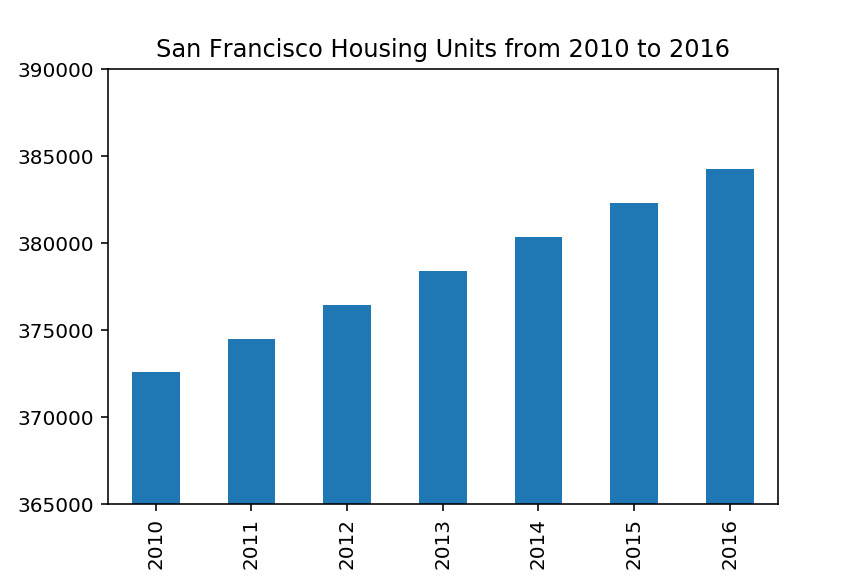

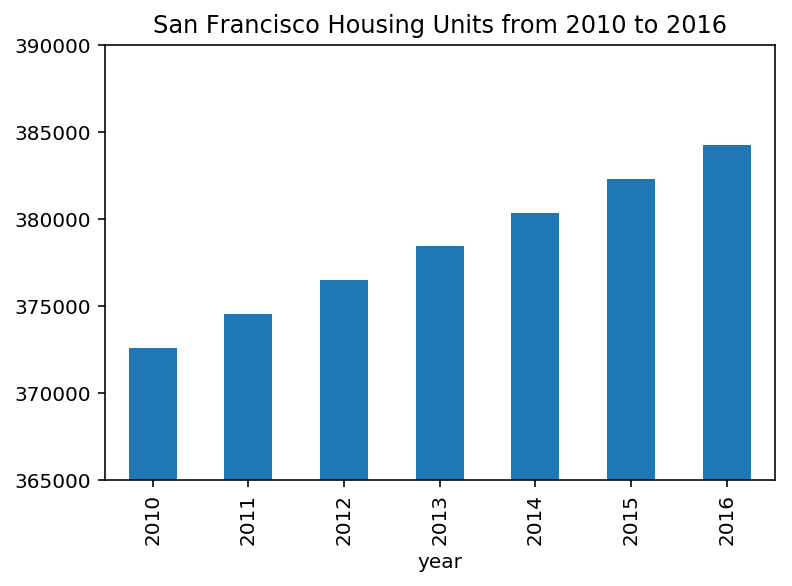

In [66]:
housing_units_per_year()

Matplotlib(Figure)
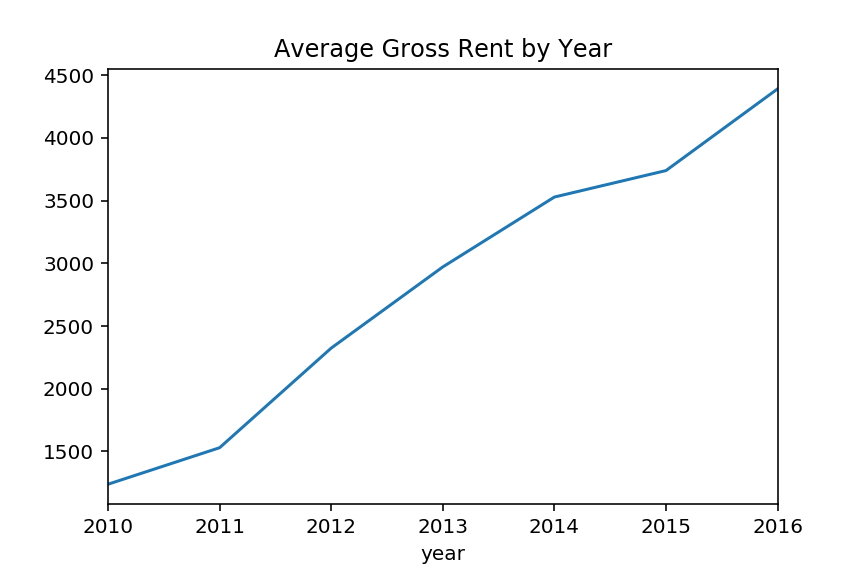

In [65]:
average_gross_rent()

Matplotlib(Figure)
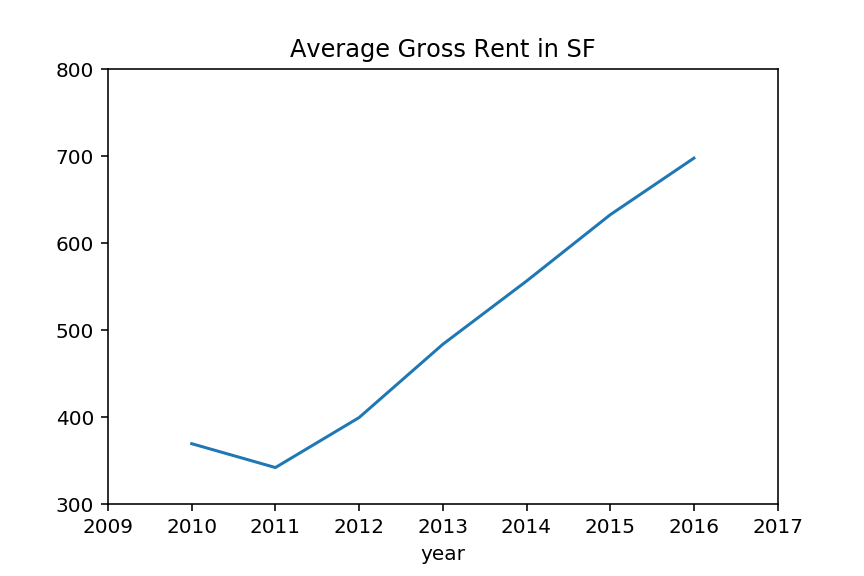

In [64]:
average_sales_price()

In [63]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [47]:
top_most_expensive_neighborhoods()

,sale_price_sqr_foot
neighborhood,
Union Square District,903.993258
Merced Heights,788.844818
Miraloma Park,779.810842
Pacific Heights,689.555817
Westwood Park,687.087575
Telegraph Hill,676.506578
Presidio Heights,675.350212
Cow Hollow,665.964042
Potrero Hill,662.013613


In [48]:
most_expensive_neighborhoods_rent_sales()

,gross_rent
neighborhood,
Westwood Park,3959.000000
Bayview Heights,3739.000000
Visitacion Valley,3657.000000
Silver Terrace,3528.000000
Merced Heights,3414.000000
Inner Parkside,3224.000000
Mission Terrace,3173.400000
Bernal Heights,3080.333333
Anza Vista,3031.833333


In [67]:
#neighborhood_map().show()

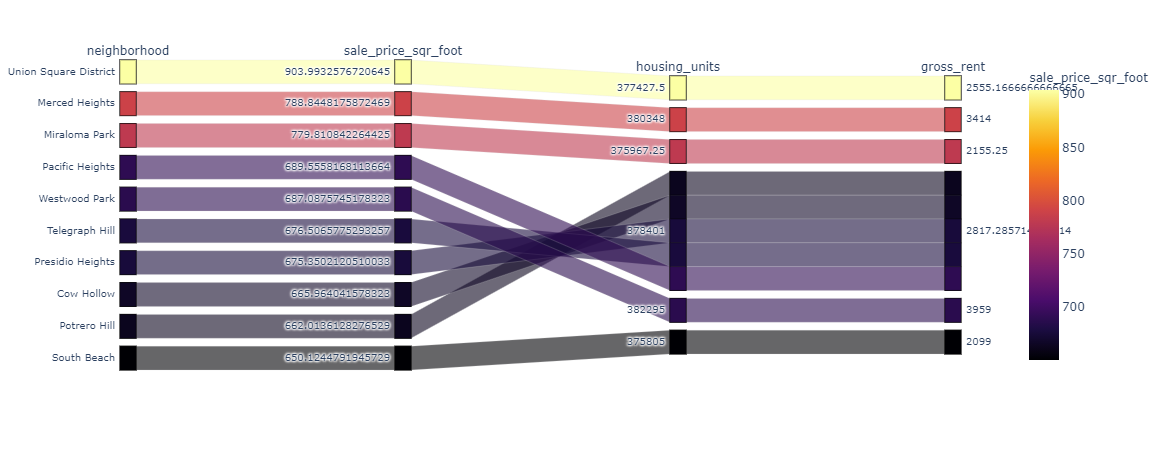

In [55]:
parallel_categories()

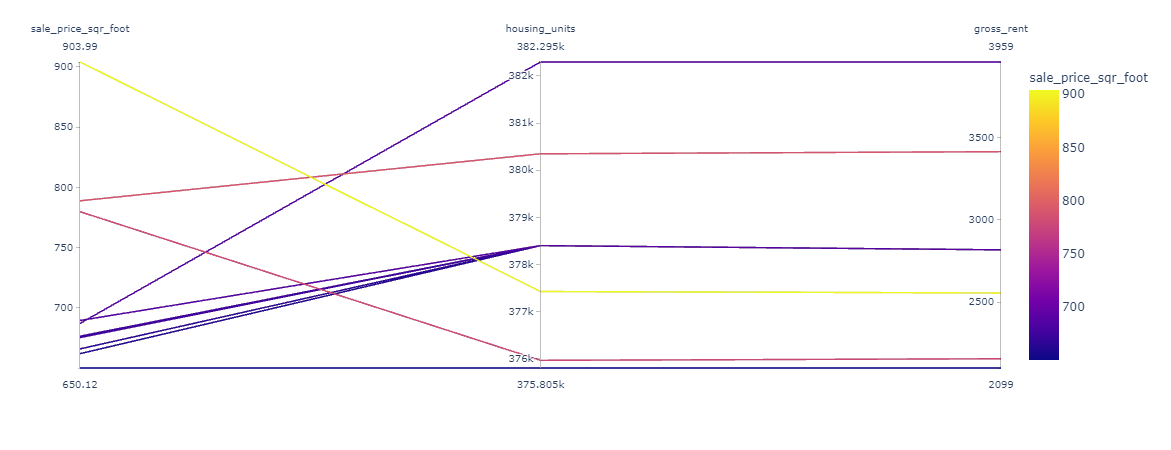

In [56]:
parallel_coordinates()

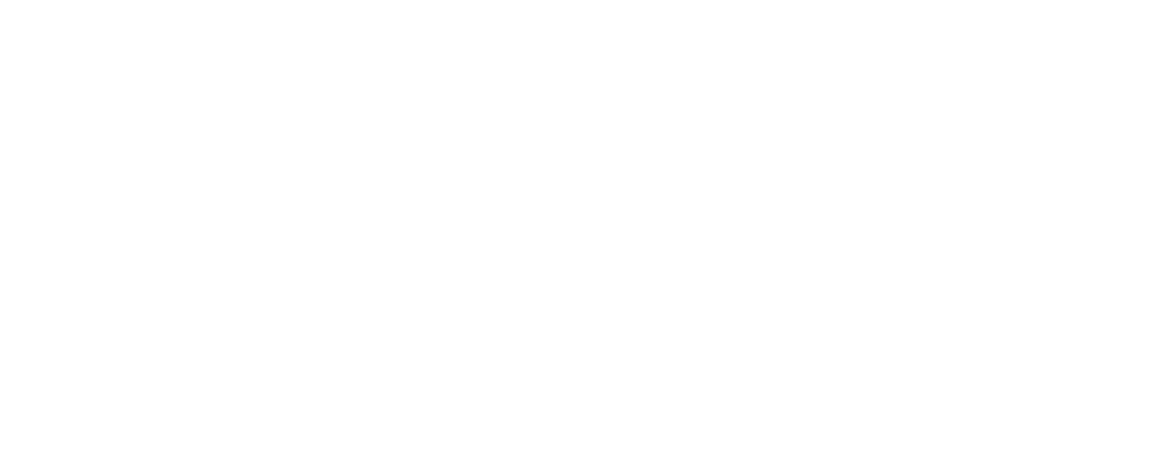

In [61]:
sunburst()